In [1]:
from typing import List, Tuple, Optional, Any

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
class Bandit:
    def __init__(
        self,
        mu: float,
        std: float,
        Q: float = 0.0,
        alpha: float = 0.1,
        mode: str = "sample_avg",
        delta: float = 1e-10,
    ):
        assert mode in [
            "constant",
            "sample_avg",
        ], f"Expected mode to be either constant/sample_avg. Found mode to be {mode}"

        self._mu = mu
        self._std = std
        self._Q = Q
        self._alpha = alpha
        self._N = 0 + delta
        self._mode = mode

    def pull(self) -> float:
        return np.random.normal(loc=self._mu, scale=self._std)

    def update(self, r: float):
        alpha = 0.0
        self._N += 1
        if self._mode == "constant":
            alpha = self._alpha
        else:
            alpha = 1 / self._N

        self._Q += alpha * (r - self._Q)

    @property
    def true_val(self):
        return self._mu

    @property
    def Q(self):
        return self._Q

    @property
    def N(self):
        return self._N

In [3]:
def single_run(
    bandits: List[Bandit],
    n_steps: int,
    eps: float,
    strategy: str = "eps-greedy",
    c: int = 2,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    assert strategy in [
        "eps-greedy",
        "ucb",
    ], f"Strategy can be either eps-greedy/ucb. Found strategy to be {strategy}"

    def calc_ub(bandit: Bandit, c: int, t: int):
        return c * np.sqrt(np.log(t) / bandit.N)

    rewards = np.zeros(n_steps)
    optimals = np.zeros(n_steps)
    selected_actions = np.zeros(n_steps)
    optimal_bandit = int(np.argmax([b.true_val for b in bandits]))

    if strategy == "eps-greedy":
        for i in range(n_steps):
            if np.random.rand() < eps:
                bandit = np.random.choice(len(bandits))
            else:
                bandit = np.argmax([b.Q for b in bandits])

            bandit = int(bandit)
            r = bandits[bandit].pull()
            bandits[bandit].update(r)

            rewards[i] = r
            optimals[i] = 1 if bandit == optimal_bandit else 0
            selected_actions[i] = bandit
    else:
        for i in range(len(bandits)):
            r = bandits[i].pull()
            bandits[i].update(r)

            rewards[i] = r
            optimals[i] = 1 if i == optimal_bandit else 0
            selected_actions[i] = i

        for i in range(len(bandits), n_steps):
            bandit = int(
                np.argmax([b.Q + calc_ub(bandit=b, c=c, t=i) for b in bandits])
            )
            r = bandits[bandit].pull()
            bandits[bandit].update(r)

            rewards[i] = r
            optimals[i] = 1 if bandit == optimal_bandit else 0
            selected_actions[i] = bandit

    return rewards, optimals, selected_actions

In [4]:
def run_experiment(
    true_means: np.ndarray,
    true_sigmas: np.ndarray,
    n_runs: int,
    n_steps: int,
    Q: float = 0.0,
    alpha: float = 0.1,
    mode: str = "sample_avg",
    strategy: str = "eps-greedy",
    c: int = 2,
    eps: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    all_rewards = np.zeros((n_runs, n_steps))
    all_optimals = np.zeros((n_runs, n_steps))
    all_selected_actions = np.zeros((n_runs, n_steps))

    for i in range(n_runs):
        bandits = [
            Bandit(mu=mu, std=sigma, Q=Q, alpha=alpha, mode=mode)
            for (mu, sigma) in zip(true_means, true_sigmas)
        ]
        rewards, optimals, selected_actions = single_run(
            bandits=bandits, n_steps=n_steps, eps=eps, strategy=strategy, c=c
        )
        all_rewards[i] = rewards
        all_optimals[i] = optimals
        all_selected_actions[i] = selected_actions

    return all_rewards.mean(axis=0), all_optimals.mean(axis=0), all_selected_actions

In [5]:
K = 10
N_RUNS = 2000
N_STEPS = 1000
MEANS = np.random.randn(K)
SIGMAS = np.random.rand(K)

In [6]:
exp_r_1, exp_o_1, exp_a_1 = run_experiment(
    true_means=MEANS,
    true_sigmas=SIGMAS,
    n_runs=N_RUNS,
    n_steps=N_STEPS,
    mode="sample_avg",
)
exp_r_2, exp_o_2, exp_a_2 = run_experiment(
    true_means=MEANS,
    true_sigmas=SIGMAS,
    n_runs=N_RUNS,
    n_steps=N_STEPS,
    strategy="ucb",
    mode="sample_avg",
)

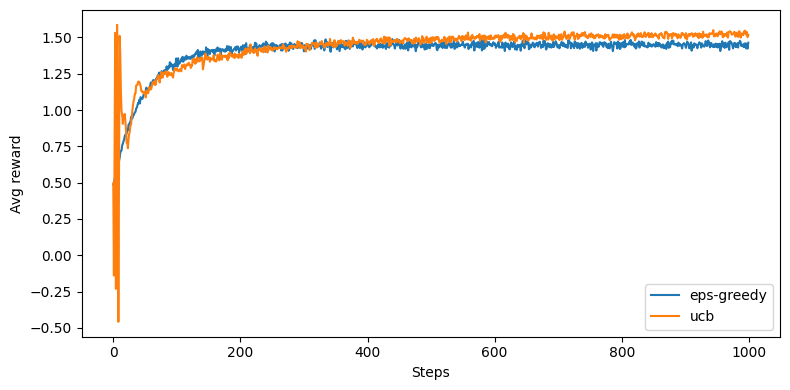

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(exp_r_1, label="eps-greedy")
plt.plot(exp_r_2, label="ucb")
plt.ylabel("Avg reward")
plt.xlabel("Steps")
plt.legend()
plt.tight_layout()
plt.show()

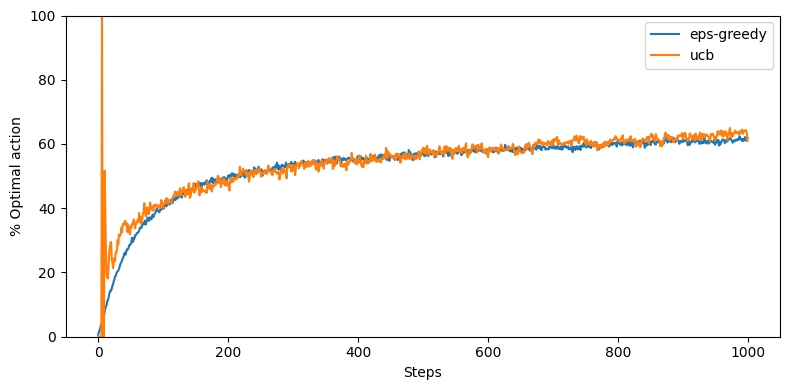

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(exp_o_1 * 100, label="eps-greedy")
plt.plot(exp_o_2 * 100, label="ucb")
plt.ylim(0, 100)
plt.ylabel("% Optimal action")
plt.xlabel("Steps")
plt.legend()
plt.tight_layout()
plt.show()

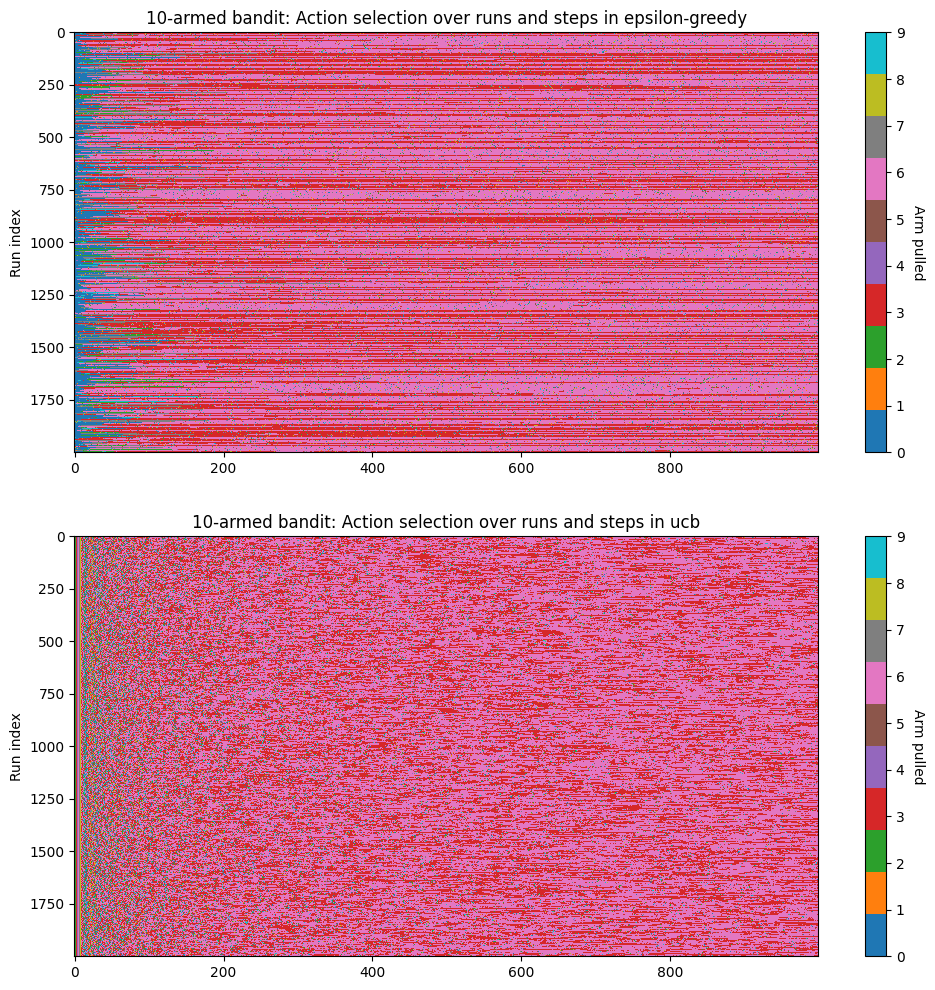

In [9]:
def plot_img(img_data: np.ndarray, k: int, ax: plt.Axes, fig: plt.Figure, title):
    cmap = plt.get_cmap("tab10", k)
    img = ax.imshow(
        img_data, cmap=cmap, aspect="auto", interpolation="nearest", vmin=0, vmax=k - 1
    )
    cbar = fig.colorbar(img, ax=ax, ticks=range(k), orientation="vertical")
    cbar.set_label("Arm pulled", rotation=270, labelpad=15)
    ax.set_ylabel("Run index")
    ax.set_title(title)


fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax = ax.flatten()

plot_img(
    exp_a_1,
    k=K,
    ax=ax[0],
    fig=fig,
    title="10-armed bandit: Action selection over runs and steps in epsilon-greedy",
)
plot_img(
    exp_a_2,
    k=K,
    ax=ax[1],
    fig=fig,
    title="10-armed bandit: Action selection over runs and steps in ucb",
)